<a href="https://colab.research.google.com/github/wilikki107/KYBS3050/blob/main/KYBS3050_harjoitustyo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.1.2-py3-none-any.whl size=190292 sha256=2b8b1cf38b70e578e4257d0175a02a7c417bc285762b0636bf212f593d7f87df
  Stored in directory: /root/.cache/pip/wheels/81/1b/61/aa85b78c3c0c8871f4231e3f4a03bb23cecb7db829498380ee
Successfully built pyod


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout

from google.colab import drive

drive.mount('/content/gdrive/')



Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# Yleistä

Käytetään "CSE-CIC-IDS2018 on AWS" datasetistä yhden päivän flowdataa sisältävää CSV:tä. Kyseisessä datasetissä pitäisi olla DDOS-LOIC-UDP ja DDOS-HOIC hyökkäysten dataa näkyvissä.

DDOS-LOIC-UDP hyökkäykset on tehty "legendaarisella" Low Orbit Ion Cannon työkalulla. Työkalun ja datasetin kuvauksen perusteella kohteisiin on ammuttu UDP paketteja suurissa määrissä useita eri lähteistä ja pyritty siten saamaan palvelunesto aikaiseksi.

DDOS-HOIC hyökkäykset on tehty LOIC työkalun seuraajalla eli High Orbit Ion Cannonilla. Datan perusteella HOIC hyökkäyksissä on käytetty TCP:tä.

Tavoite on yrittää löytää datasetistä nämä hyökkäykset tavalla tai toisella koneoppimista hyödyntäen.

In [3]:
path = "/content/gdrive/MyDrive/KYBS3050/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv"

dataset = pd.read_csv(path)
dataset

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,6,21/02/2018 08:33:25,37953,5,3,135,127,135,0,...,32,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1,500,17,21/02/2018 08:33:06,117573474,3,0,1500,0,500,500,...,8,0.0,0.0,0,0,58800000.0,23800000.0,75600000,42000000,Benign
2,500,17,21/02/2018 08:33:06,117573474,3,0,1500,0,500,500,...,8,0.0,0.0,0,0,58800000.0,23800000.0,75600000,42000000,Benign
3,500,17,21/02/2018 08:33:11,99743998,5,0,2500,0,500,500,...,8,4000290.0,0.0,4000290,4000290,31900000.0,37900000.0,75600000,7200397,Benign
4,500,17,21/02/2018 08:33:11,99743999,5,0,2500,0,500,500,...,8,4000286.0,0.0,4000286,4000286,31900000.0,37900000.0,75600000,7200399,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,55484,6,21/02/2018 02:33:29,1252,5,2,935,274,935,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048571,57624,6,21/02/2018 02:33:29,19055,5,2,935,341,935,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048572,57623,6,21/02/2018 02:33:29,36677,5,2,935,341,935,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048573,57625,6,21/02/2018 02:33:29,1849,5,2,935,341,935,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign


# Datasetin tiedot

Dataa on reilu miljoon riviä ja 80 saraketta. Yllättäen flowdatasta näyttää kuitenkin puuttuvan lähde- ja kohdeosoitteet, mitkä esim. standardiin NetFlow formaattiin kuuluvat.

In [4]:
dataset.info()

print()

dataset['Label'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1048575 non-null  int64  
 1   Protocol           1048575 non-null  int64  
 2   Timestamp          1048575 non-null  object 
 3   Flow Duration      1048575 non-null  int64  
 4   Tot Fwd Pkts       1048575 non-null  int64  
 5   Tot Bwd Pkts       1048575 non-null  int64  
 6   TotLen Fwd Pkts    1048575 non-null  int64  
 7   TotLen Bwd Pkts    1048575 non-null  int64  
 8   Fwd Pkt Len Max    1048575 non-null  int64  
 9   Fwd Pkt Len Min    1048575 non-null  int64  
 10  Fwd Pkt Len Mean   1048575 non-null  float64
 11  Fwd Pkt Len Std    1048575 non-null  float64
 12  Bwd Pkt Len Max    1048575 non-null  int64  
 13  Bwd Pkt Len Min    1048575 non-null  int64  
 14  Bwd Pkt Len Mean   1048575 non-null  float64
 15  Bwd Pkt Len Std    1048575 non-n

DDOS attack-HOIC        686012
Benign                  360833
DDOS attack-LOIC-UDP      1730
Name: Label, dtype: int64

Labelien tarkastelun/laskemisen perusteella datan riveistä enemmistö on haitallista HOICin liikennettä:

DDOS attack-HOIC        686012

Benign                  360833

DDOS attack-LOIC-UDP      1730

Jos haitallista liikennettä on enemmän kuin normaalia, voi poikkeaman havaitsemisesta tulla äkkiä hieman vääristynyttä. Hyökkäysten aikaleimat ovat kuitenkin tiedossa, joten dataa paloittelemalla aikaleimoja rajaamalla voi yrittää tilannetta paikata.

DDOS-LOIC-UDP 10:09 - 10:45

DDOS-HOIC 14:05 - 15:05

Yllä olevan datasetin tulosteen perusteella aikaleimojen perusteella kumpaakaan aikaikkunaa ei setistä löytyisi elleivät aikaleimat ole 12h kellolla. Tarkastetaan miltä DDOS-HOIC aikaleimat setissä näyttävät.

In [5]:
dataset.loc[dataset['Label'] == 'DDOS attack-HOIC']

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
3930,80,6,21/02/2018 02:11:08,31105,3,4,336,935,336,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
3931,80,6,21/02/2018 02:11:08,30092,3,4,336,935,336,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
3932,80,6,21/02/2018 02:11:08,33993,3,4,336,935,336,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
3933,80,6,21/02/2018 02:11:08,33099,3,4,336,935,336,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
3934,80,6,21/02/2018 02:11:08,32149,3,4,336,935,336,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048563,80,6,21/02/2018 02:33:29,10855,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
1048564,80,6,21/02/2018 02:33:29,1330,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
1048565,80,6,21/02/2018 02:33:29,1638,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC
1048568,80,6,21/02/2018 02:33:29,1480,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,DDOS attack-HOIC


Aikaleimat ovat siis tosiaan 12h kellolla, joten oikeat käytettävät aikaleimat ovat:

DDOS-LOIC-UDP 10:09 - 10:45

DDOS-HOIC 02:05 - 03:05, käytännössä 02:05 - 02:33, koska siihen datasetti päättyy.

Lisäksi yllä olevasta nähdään, että HOIC käyttää TCP:tä: 'Protocol' sarakkeen numero 6 viittaa TCP:hen. Vastaavasti UDP:n numero on 17.

<Axes: title={'center': 'Number of attacks'}>

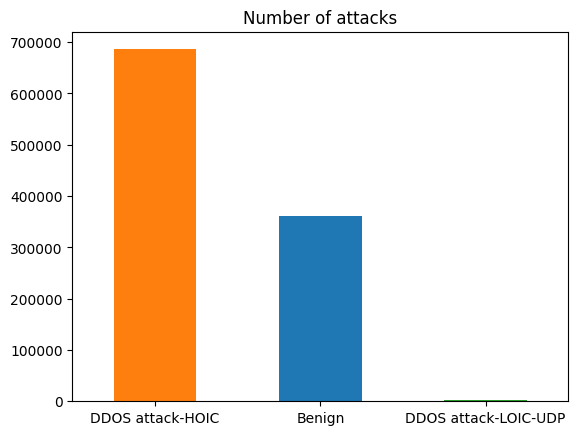

In [5]:
my_colors = ['r', 'g', 'o']

dataset.Label.value_counts().plot(kind='bar', title="Number of attacks", rot=0, color=['C1', 'C0', 'C2'])

# Datan splittaus

Splitataan data koulutus ja testisetteihin. Tarkoitus on kokeilla kahta eri mallia:

1. LOIC hyökkäysten tunnistaminen
2. LOIC & HOIC hyökkäysten tunnistaminen samalla mallilla


## LOIC data


Tehdään uusi datasetti, jossa on vain normaalia liikennettä ja LOIC liikennettä. Lisäksi muutetan label kentän arvot:

* Normaali = 0
* Haitallinen = 1

Poistetaan timestamp sarake turhana, erotetaan taustatotuus erilliseksi matriisiksi ja muunnetaan sekä taustatotuus että data numpy arrayksi. Lopuksi jaetaan data koulutus- ja testidatoihin.

In [15]:
#print(dataset.shape)

# Poistetaan HOIC liikenne datasta ja jätetään vain normaali & LOIC
LOIC_df = dataset[dataset["Label"].isin(['Benign','DDOS attack-LOIC-UDP'])].copy()

#print(dataset.shape)

# Muutetaan label kentän arvot numeerisiksi
LOIC_df.replace(to_replace="Benign", value=0, inplace=True)
LOIC_df.replace(to_replace="DDOS attack-LOIC-UDP", value=1, inplace=True)

# Hävitetään timestamp
LOIC_df.drop('Timestamp', axis=1, inplace=True)

# Tehdään luokittain olevat kopiot
clean = LOIC_df[LOIC_df.Label == 0]
evil = LOIC_df[LOIC_df.Label == 1]

# Poistetaan label ja tehdään siitä taustatotuus
T_LOIC_df = np.array(LOIC_df.pop("Label"))

#print(LOIC_df.info())

# Muutetaan dataframe numpy arrayksi
X_LOIC_df = LOIC_df.to_numpy()

#print(type(X_LOIC_df))
#print(X_LOIC_df.shape)
#print(type(T_LOIC_df))
#print(T_LOIC_df.shape)

# Jaetaan koulutus- ja testidataan (X) sekä vastaaviin taustatotuuksiin (T)
X_LOIC_train, X_LOIC_test, T_LOIC_train, T_LOIC_test = train_test_split(X_LOIC_df, T_LOIC_df, test_size=0.2, random_state=42)

print(X_LOIC_train.shape)
print(X_LOIC_test.shape)
print(T_LOIC_train.shape)
print(T_LOIC_test.shape)

(290050, 78)
(72513, 78)
(290050,)
(72513,)


## LOIC & HOIC data

In [6]:
COMBINED_df = dataset.copy()

# Hävitetään timestamp
COMBINED_df.drop('Timestamp', axis=1, inplace=True)

# Muutetaan label kentän arvot numeerisiksi
COMBINED_df.replace(to_replace="Benign", value=0, inplace=True)
COMBINED_df.replace(to_replace="DDOS attack-LOIC-UDP", value=1, inplace=True)
COMBINED_df.replace(to_replace="DDOS attack-HOIC", value=1, inplace=True)

#print(COMBINED_df['Label'].value_counts())

# Tehdään luokittain olevat kopiot
COMBINED_clean = COMBINED_df[COMBINED_df.Label == 0]
COMBINED_evil = COMBINED_df[COMBINED_df.Label == 1]

# Poistetaan label ja tehdään siitä taustatotuus
T_COMBINED_df = np.array(COMBINED_df.pop("Label"))

print(T_COMBINED_df.shape)

# Muutetaan dataframe numpy arrayksi
X_COMBINED_df = COMBINED_df.to_numpy()

# Jaetaan koulutus- ja testidataan (X) sekä vastaaviin taustatotuuksiin (T)
X_COMBINED_train, X_COMBINED_test, T_COMBINED_train, T_COMBINED_test = train_test_split(X_COMBINED_df, T_COMBINED_df, test_size=0.2, random_state=42)

print(X_COMBINED_train.shape)
print(X_COMBINED_test.shape)
print(T_COMBINED_train.shape)
print(T_COMBINED_test.shape)

(1048575,)
(838860, 78)
(209715, 78)
(838860,)
(209715,)


# LOIC

## Normalisointi

In [16]:
scaler = preprocessing.MinMaxScaler()
X_LOIC_train_norm = scaler.fit_transform(X_LOIC_train)
X_LOIC_test_norm = scaler.transform(X_LOIC_test)

print(X_LOIC_train_norm.shape)
print(X_LOIC_test_norm.shape)

(290050, 78)
(72513, 78)


## PCA

Kokeillaan saako jakoavaimella mitään aikaiseksi.

Singulaariarvot: [171.8747555  106.87099906]
Variance ratio: [0.64627799 0.24987046]


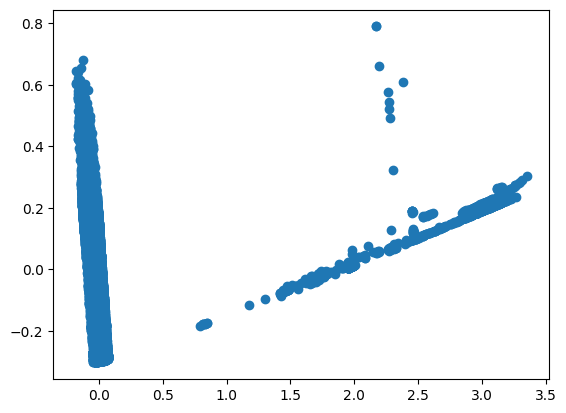

In [17]:
# Kaksi pääkomponenttia selittää datan noin 90% ja loput ovat hyvin merkityksettömiä, joten n=2
#pca = PCA(n_components=5)
pca = PCA(n_components=2)
X_LOIC_train_pca = pca.fit_transform(X_LOIC_train_norm)
X_LOIC_test_pca = pca.transform(X_LOIC_test_norm)

print('Singulaariarvot: '+ str(pca.singular_values_))
print('Variance ratio: ' + str(pca.explained_variance_ratio_))

plt.scatter(X_LOIC_train_pca[:,0],X_LOIC_train_pca[:,1])
plt.show()

## CBLOF

CBLOF (Cluster based outlier detection) näyttää toimivan kohtuullisesti.

In [14]:
clf_name = 'CBLOF'
clf = CBLOF()
clf.fit(X_LOIC_train_pca)

#Predict palauttaa arrayn, jossa 1=anomalia 0=normaalia
outlier_labels_train = clf.predict(X_LOIC_train_pca)
#Where palauttaa arrayn, jossa on anomalioiksi tunnistettujen indeksit
anomalia_train = np.where(outlier_labels_train)

#Testidatalla
outlier_labels_test = clf.predict(X_LOIC_test_pca)
anomalia_test = np.where(outlier_labels_test)

#Anomalioiden/outliers pisteet koulutus- ja testidatalle
T_train_scores = clf.decision_scores_
T_test_scores = clf.decision_function(X_LOIC_test_pca)

print("\nLuokitteluraportti koulutusdatalla:")
print(classification_report(T_LOIC_train, outlier_labels_train, labels=[0, 1]))

print("\nLuokitteluraportti testidatalla:")
print(classification_report(T_LOIC_test, outlier_labels_test, labels=[0, 1]))
print()
print("\nKoulutusdatalla:")
evaluate_print(clf_name, T_LOIC_train, T_train_scores)
print("\nTestidatalla:")
evaluate_print(clf_name, T_LOIC_test, T_test_scores)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Luokitteluraportti koulutusdatalla:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    288684
           1       0.05      1.00      0.09      1366

    accuracy                           0.90    290050
   macro avg       0.52      0.95      0.52    290050
weighted avg       1.00      0.90      0.95    290050


Luokitteluraportti testidatalla:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     72149
           1       0.05      1.00      0.10       364

    accuracy                           0.90     72513
   macro avg       0.52      0.95      0.52     72513
weighted avg       1.00      0.90      0.95     72513



Koulutusdatalla:
CBLOF ROC:0.9996, precision @ rank n:0.8851

Testidatalla:
CBLOF ROC:0.9996, precision @ rank n:0.8874


## ABOD

ABODin tuloksella ei juuri juhlita. Optimoimalla voisi ehkä päästä parempaan tulokseen.

In [18]:
from pyod.models.abod import ABOD

clf_name = 'ABOD'
clf = ABOD(contamination=0.05, n_neighbors=5, method='fast')
clf.fit(X_LOIC_train_pca)

#Predict palauttaa arrayn, jossa 1=anomalia 0=normaalia
outlier_labels_train = clf.predict(X_LOIC_train_pca)
#Where palauttaa arrayn, jossa on anomalioiksi tunnistettujen indeksit
anomalia_train = np.where(outlier_labels_train)

#Testidatalla
outlier_labels_test = clf.predict(X_LOIC_test_pca)
anomalia_test = np.where(outlier_labels_test)

#Anomalioiden/outliers pisteet koulutus- ja testidatalle
T_train_scores = clf.decision_scores_
T_test_scores = clf.decision_function(X_LOIC_test_pca)

print("\nLuokitteluraportti koulutusdatalla:")
print(classification_report(T_LOIC_train, outlier_labels_train, labels=[0, 1]))

print("\nLuokitteluraportti testidatalla:")
print(classification_report(T_LOIC_test, outlier_labels_test, labels=[0, 1]))
print()
print("\nKoulutusdatalla:")
evaluate_print(clf_name, T_LOIC_train, T_train_scores)
print("\nTestidatalla:")
evaluate_print(clf_name, T_LOIC_test, T_test_scores)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)



Luokitteluraportti koulutusdatalla:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    288684
           1       0.01      0.10      0.02      1366

    accuracy                           0.95    290050
   macro avg       0.50      0.53      0.50    290050
weighted avg       0.99      0.95      0.97    290050


Luokitteluraportti testidatalla:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     72149
           1       0.01      0.08      0.01       364

    accuracy                           0.95     72513
   macro avg       0.50      0.51      0.49     72513
weighted avg       0.99      0.95      0.97     72513



Koulutusdatalla:
ABOD ROC:0.3106, precision @ rank n:0.0666

Testidatalla:
ABOD ROC:0.2842, precision @ rank n:0.0659


## Autoencoder

Neuroverkkojen hyödyntämiseksi poikkeamien tunnistamisessa pitää Googlen mukaan käyttää autoenkoodereita, joten sitä pitää yrittää.

Koulutusdatana käytetään täysin puhdasta dataa ilman poikkeamia ja tavoitteena on havaita poikkeamat rekonstruktiovirheen perusteella. Puhtaalla datalla virheen pitäisi olla pieni ja poikkeavalla datalla suuri, joten poikkeamat pitäisi olla löydettävissä raja-arvon perusteella.

Dataa on käsitelty jo aikaisemmin, mutta koska autoenkooderi tarvitsee täysin puhdasta dataa, niin käsittelyä joudutaan tekemään tässä yhteydessä uusiksi.

In [19]:
# Koulutusdatana käytetään pelkkää normaalidataa ilman anomalioita
print(f"""Datasetit:
    clean (rows, cols) = {clean.shape}
    evil (rows, cols) = {evil.shape}""")

# Sekoitetaan koulutusdata
clean = clean.sample(frac=1).reset_index(drop=True)

# Koulutussetti ilman pahuutta
X_train = clean.iloc[:300000]
T_train = X_train.pop('Label')

# Testisetti, jossa loput puhtaat ja pahuus
X_test = clean[300000:].copy()
# Täysin puhdas testisetti
X_clean_test = X_test.drop(labels='Label', axis=1).copy()
# Yhdistetään puhdas testisetti ja pahuus lopulliseksi testisetiksi
X_test = pd.concat([X_test, evil])
X_test = X_test.sample(frac=1)
T_test = X_test.pop('Label')

# Pelkkää pahuutta sisältävä testisetti
X_evil_test = evil.drop(labels='Label', axis=1).copy()

#print(T_train.value_counts())
#print(T_test.value_counts())

Datasetit:
    clean (rows, cols) = (360833, 79)
    evil (rows, cols) = (1730, 79)


Data jaetaan kolmeen osaan: koulutus, validointi ja testi. Koulutus ja validointi ovat täysin puhtaita ja testidata sisältää kaikki poikkeamat (eli tässä tapauksessa LOIC liikenteen).

In [20]:
# Splitataan puhdas koulutusdata validointiin ja koulutusdataan sekä labeleihin
X_train, X_validate, T_train, T_validate = train_test_split(X_train, T_train,
                                                            test_size=0.2,
                                                            random_state=42)

# Muutetaan dataframet -> numpy array
X_train = X_train.values
X_validate = X_validate.values
X_test = X_test.values
T_train = T_train.values
T_validate = T_validate.values
T_test = T_test.values
X_evil_test = X_evil_test.values
X_clean_test = X_clean_test.values

Erilliset puhdas ja paha testisetti ovat loppujen lopuksi aika turhia, mutta testaillessa ja ongelmia selvittäessä niille oli käyttöä.

In [21]:
print(f"""Datasettien muodot:
    Koulutus (rows, cols) = {X_train.shape}
    Validointi (rows, cols) = {X_validate.shape}
    Testi (rows, cols) = {X_test.shape}
    Koulutuslabelit (rows, cols) = {T_train.shape}
    Validointilabelit (rows, cols) = {T_validate.shape}
    Testilabelit (rows, cols) = {T_test.shape}
    Testi pelkällä pahuudella (rows, cols) = {X_evil_test.shape}
    Testi ilman pahuutta (rows, cols) = {X_clean_test.shape}  """)

Datasettien muodot:
    Koulutus (rows, cols) = (240000, 78)
    Validointi (rows, cols) = (60000, 78)
    Testi (rows, cols) = (62563, 78)
    Koulutuslabelit (rows, cols) = (240000,)
    Validointilabelit (rows, cols) = (60000,)
    Testilabelit (rows, cols) = (62563,)
    Testi pelkällä pahuudella (rows, cols) = (1730, 78)
    Testi ilman pahuutta (rows, cols) = (60833, 78)  


### Normalisointi

Normalisoidaan pilkottu data.

In [22]:
scaler = preprocessing.MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_validate_norm = scaler.transform(X_validate)
X_test_norm = scaler.transform(X_test)
X_evil_test_norm = scaler.transform(X_evil_test)
X_clean_test_norm = scaler.transform(X_clean_test)

### Malli

Luodaan autoenkooderin malli. Tämä on tarpeettoman raskas ja hidas, mutta optimointiin ei ollut tässä yhteydessä aikaa. Todennäköisesti neuronien määrää voisi ainakin supistaa ja eräkokoa (BATCH) suurentaa.

Activation funktio, optimizer ja loss on valittu ihan vain Internetistä löytyneiden esimerkkien perusteella ilman tarkempaa pohdintaa.

In [23]:
DIMENSION = X_train_norm.shape[1]
BATCH = 16
EPOCHS = 10
ACT = 'relu'

class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units

  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(DIMENSION, activation=ACT, input_shape=(DIMENSION, )),
      Dense(64, activation=ACT),
      Dense(32, activation=ACT),
      Dense(16, activation=ACT),
    ])
    self.decoder = Sequential([
      Dense(16, activation=ACT),
      Dense(32, activation=ACT),
      Dense(64, activation=ACT),
      Dense(output_units, activation='sigmoid')
    ])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AutoEncoder(output_units=X_train_norm.shape[1])
autoencoder.compile(loss='mse', optimizer='adam', metrics=["acc"])

In [24]:
history = autoencoder.fit(X_train_norm, X_train_norm,
                          epochs = EPOCHS,
                          batch_size = BATCH,
                          validation_data=(X_validate_norm, X_validate_norm))

Epoch 1/10
15000/15000 [==============================] - 58s 4ms/step - loss: 6.4509e-04 - acc: 0.0712 - val_loss: 6.0980e-05 - val_acc: 0.0639
Epoch 2/10
15000/15000 [==============================] - 57s 4ms/step - loss: 8.5625e-05 - acc: 0.0910 - val_loss: 6.0199e-05 - val_acc: 0.0058
Epoch 3/10
15000/15000 [==============================] - 56s 4ms/step - loss: 6.6323e-05 - acc: 0.1061 - val_loss: 4.6735e-05 - val_acc: 0.0364
Epoch 4/10
15000/15000 [==============================] - 55s 4ms/step - loss: 6.6974e-05 - acc: 0.0379 - val_loss: 5.8383e-05 - val_acc: 0.0058
Epoch 5/10
15000/15000 [==============================] - 51s 3ms/step - loss: 5.9004e-05 - acc: 0.0645 - val_loss: 5.5737e-05 - val_acc: 0.1375
Epoch 6/10
15000/15000 [==============================] - 51s 3ms/step - loss: 5.5407e-05 - acc: 0.3287 - val_loss: 5.5617e-05 - val_acc: 0.5091
Epoch 7/10
15000/15000 [==============================] - 52s 3ms/step - loss: 5.1162e-05 - acc: 0.4796 - val_loss: 6.0140e-05 - v

### Piirretään historia

Sekä koulutus- että validointihäviö asettuvat samalle matalalle tasolle jo muutaman kierroksen jälkeen. Epocheja on siis vähintäänkin tarpeeksi.

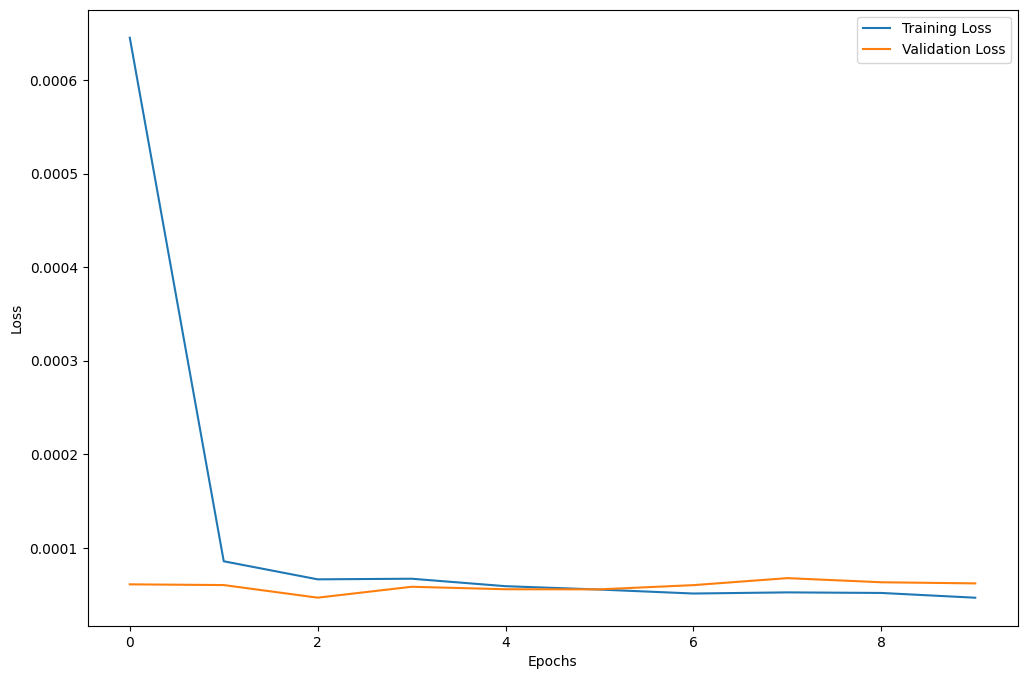

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"], label="Training Loss");
plt.plot(history.history["val_loss"], label="Validation Loss");
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

### Threshold

Edellisestä graafistakin on nähtävissä, että raja-arvo (threshold) asettuu todella matalalle. Lasketaan kuitenkin sille tarkka-arvo ajamalla koulutusdata mallin läpi ja laskemalla aritmeettinen keskiarvo palautetuille häviöille ja lisäämällä siihen häviöiden keskihajonta.

Arvot, jotka ovat pienempiä kuin raja-arvo, pitäisi olla normaaleita ja suurempien arvojen pitäisi olla poikkeamia.

In [26]:
reconstructions = autoencoder.predict(X_train_norm)
train_loss = tf.keras.losses.mse(reconstructions, X_train_norm)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

7500/7500 [==============================] - 14s 2ms/step
Threshold:  0.0011491698514888061


### Kuvien piirtelyä datasettien perusteella

Piirretään histogrammit häviöistä koulutussetillä, testisetillä (pahuus & normaalit sekaisin), puhtaalla testisetillä ja pelkkää pahuutta sisältävällä testisetillä.

Kuvien perusteella voidaan nähdä, että pahalla datalla (eli poikkeamilla) on selkeästi suuremmat häviöt, joten niiden pitäisi mennä kirkkaasti raja-arvon yli ja jäädä mallin haaviin.

55/55 [==============================] - 0s 2ms/step


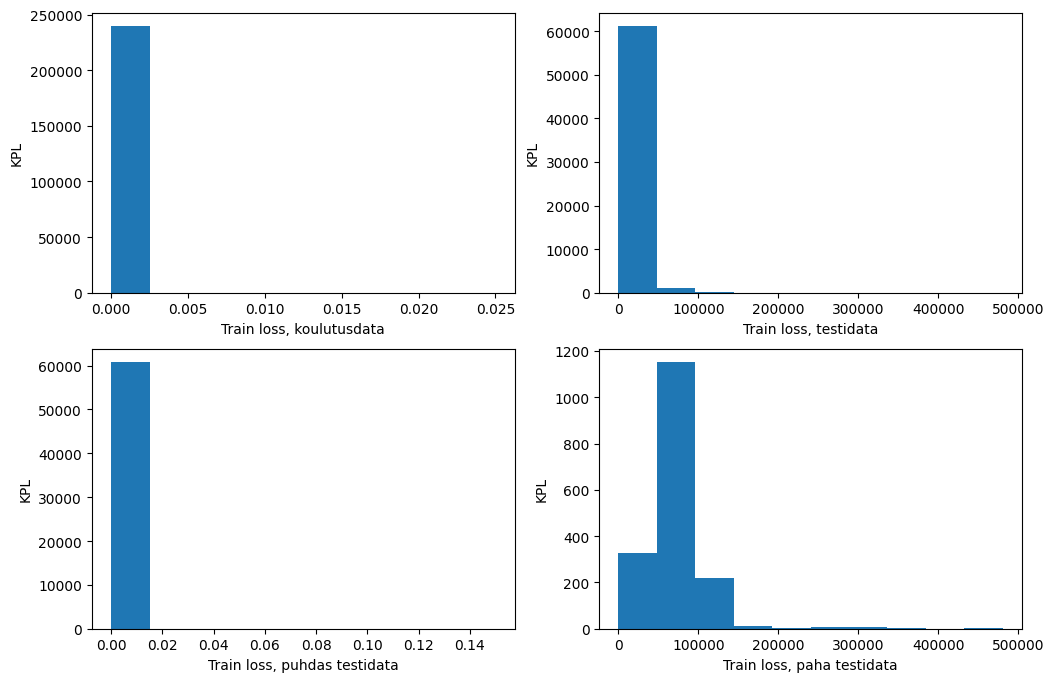

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

reconstructions = autoencoder.predict(X_train_norm)
train_loss_training = tf.keras.losses.mse(reconstructions, X_train_norm)
threshold = np.mean(train_loss_training) + np.std(train_loss)
#print("Threshold: ", threshold)
ax[0, 0].hist(train_loss_training[None,:],range=[0, 0.025])
ax[0, 0].set_xlabel('Train loss, koulutusdata')
ax[0, 0].set_ylabel('KPL')

reconstructions = autoencoder.predict(X_test_norm)
train_loss_test = tf.keras.losses.mse(reconstructions, X_test_norm)
ax[0,1].hist(train_loss_test[None,:])
ax[0,1].set_xlabel('Train loss, testidata')
ax[0,1].set_ylabel('KPL')

reconstructions = autoencoder.predict(X_clean_test_norm)
train_loss_clean = tf.keras.losses.mse(reconstructions, X_clean_test_norm)
ax[1,0].hist(train_loss_clean[None,:], range=[0, 0.15])
ax[1,0].set_xlabel('Train loss, puhdas testidata')
ax[1,0].set_ylabel('KPL')

reconstructions = autoencoder.predict(X_evil_test_norm)
train_loss_evil = tf.keras.losses.mse(reconstructions, X_evil_test_norm)
ax[1,1].hist(train_loss_evil[None,:])
ax[1,1].set_xlabel('Train loss, paha testidata')
ax[1,1].set_ylabel('KPL')

plt.show()

### Tulokset

Testidatalla laskettujen metriikoiden mukaan malli toimii LOIC-liikenteen havainnointiin oikein hyvin.

In [28]:
def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  errors = tf.keras.losses.mse(predictions, x_test_scaled)
  # 1 = poikkeama, 0 = normaali
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  return preds

preds = get_predictions(autoencoder, X_test_norm, threshold)
print(accuracy_score(preds, T_test))
print(precision_score(preds, T_test))

print("\nLuokitteluraportti testidatalla:")
print(classification_report(T_test, preds, labels=[0, 1]))

1956/1956 [==============================] - 3s 2ms/step
0.9976983200933459
1.0

Luokitteluraportti testidatalla:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60833
           1       0.92      1.00      0.96      1730

    accuracy                           1.00     62563
   macro avg       0.96      1.00      0.98     62563
weighted avg       1.00      1.00      1.00     62563



# Yhdistetty datasetti (LOIC & HOIC)

Yllä testattiin pelkkien UDP pohjaisten poikkeamien havaitsemista eri tekniikoilla. Kokeillaan saadaanko molemmat hyökkäystyypit kiinni samoilla mekanismeilla erottelematta niitä sen kummemmin.

## Normalisointi

In [7]:
scaler = preprocessing.MinMaxScaler()
X_COMBINED_train_norm = scaler.fit_transform(X_COMBINED_train)
X_COMBINED_test_norm = scaler.transform(X_COMBINED_test)

print(X_COMBINED_train_norm.shape)
print(X_COMBINED_test_norm.shape)

(838860, 78)
(209715, 78)


## PCA

PCA antaa erilaisia tuloksia, mutta toimii edelleen oikein hyvin ja kaksi pääkomponenttia selittää valtaosan datasta.

Singulaariarvot: [1217.12649148  480.44330007]
Variance ratio: [0.850648   0.13254481]


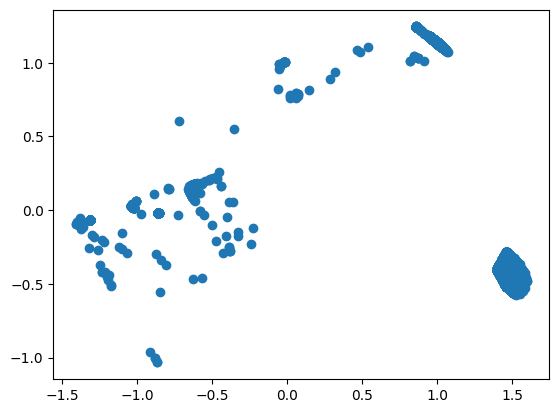

In [8]:
# Kaksi pääkomponenttia selittää datan noin 90%
# ja loput ovat hyvin merkityksettömiä, joten n=2
#pca = PCA(n_components=5)
pca = PCA(n_components=2)
X_COMBINED_train_pca = pca.fit_transform(X_COMBINED_train_norm)
X_COMBINED_test_pca = pca.transform(X_COMBINED_test_norm)

print('Singulaariarvot: '+ str(pca.singular_values_))
print('Variance ratio: ' + str(pca.explained_variance_ratio_))

plt.scatter(X_COMBINED_train_pca[:,0],X_COMBINED_train_pca[:,1])
plt.show()

## CBLOF

CBLOF ei näytä toimivan molemmat hyökkäystyypit sisältävälle datasetille kovin vahvasti.

In [9]:
clf_name = 'CBLOF'
clf = CBLOF()
clf.fit(X_COMBINED_train_pca)

#Predict palauttaa arrayn, jossa 1=anomalia 0=normaalia
outlier_labels_train = clf.predict(X_COMBINED_train_pca)
#Where palauttaa arrayn, jossa on anomalioiksi tunnistettujen indeksit
anomalia_train = np.where(outlier_labels_train)

#Testidatalla
outlier_labels_test = clf.predict(X_COMBINED_test_pca)
anomalia_test = np.where(outlier_labels_test)

#Anomalioiden/outliers pisteet koulutus- ja testidatalle
T_train_scores = clf.decision_scores_
T_test_scores = clf.decision_function(X_COMBINED_test_pca)

print("\nLuokitteluraportti koulutusdatalla:")
print(classification_report(T_COMBINED_train, outlier_labels_train, labels=[0, 1]))

print("\nLuokitteluraportti testidatalla:")
print(classification_report(T_COMBINED_test, outlier_labels_test, labels=[0, 1]))
print()
print("\nKoulutusdatalla:")
evaluate_print(clf_name, T_COMBINED_train, T_train_scores)
print("\nTestidatalla:")
evaluate_print(clf_name, T_COMBINED_test, T_test_scores)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Luokitteluraportti koulutusdatalla:
              precision    recall  f1-score   support

           0       0.31      0.81      0.45    288750
           1       0.34      0.05      0.09    550110

    accuracy                           0.31    838860
   macro avg       0.33      0.43      0.27    838860
weighted avg       0.33      0.31      0.21    838860


Luokitteluraportti testidatalla:
              precision    recall  f1-score   support

           0       0.31      0.81      0.45     72083
           1       0.34      0.05      0.09    137632

    accuracy                           0.31    209715
   macro avg       0.33      0.43      0.27    209715
weighted avg       0.33      0.31      0.21    209715



Koulutusdatalla:
CBLOF ROC:0.0944, precision @ rank n:0.4751

Testidatalla:
CBLOF ROC:0.0945, precision @ rank n:0.4763


## Autoenkooderi

Autoenkooderi on käytännössä vain kopioitu yltä, jopa muuttujat pysyvät samoina (siksi niiden nollaus alussa). Neuroverkon neuronien määrää on kuitenkin pienennetty ja eräkokoa kasvatettu, että tämä menisi nopeammin läpi.

In [10]:
X_train = None
T_train = None
X_test = None
T_test = None
X_clean_test = None
X_evil_test = None

# Koulutusdatana käytetään pelkkää normaalidataa ilman anomalioita
print(f"""Datasetit:
    clean (rows, cols) = {COMBINED_clean.shape}
    evil (rows, cols) = {COMBINED_evil.shape}""")

# Sekoitetaan koulutusdata
COMBINED_clean = COMBINED_clean.sample(frac=1).reset_index(drop=True)

# Koulutussetti ilman pahuutta
X_train = COMBINED_clean.iloc[:300000]
T_train = X_train.pop('Label')

# Testisetti, jossa loput puhtaat ja pahuus
X_test = COMBINED_clean[300000:].copy()
# Täysin puhdas testisetti
X_clean_test = X_test.drop(labels='Label', axis=1).copy()
# Yhdistetään puhdas testisetti ja pahuus lopulliseksi testisetiksi
X_test = pd.concat([X_test, COMBINED_evil])
X_test = X_test.sample(frac=1)
T_test = X_test.pop('Label')

# Pelkkää pahuutta sisältävä testisetti
X_evil_test = COMBINED_evil.drop(labels='Label', axis=1).copy()

print(X_train.shape)
print(X_test.shape)

Datasetit:
    clean (rows, cols) = (360833, 79)
    evil (rows, cols) = (687742, 79)
(300000, 78)
(748575, 78)


In [11]:
# Splitataan puhdas koulutusdata validointiin ja koulutusdataan sekä labeleihin
X_train, X_validate, T_train, T_validate = train_test_split(X_train, T_train,
                                                            test_size=0.2,
                                                            random_state=42)

# Muutetaan dataframet -> numpy array
X_train = X_train.values
X_validate = X_validate.values
X_test = X_test.values
T_train = T_train.values
T_validate = T_validate.values
T_test = T_test.values
X_evil_test = X_evil_test.values
X_clean_test = X_clean_test.values

In [12]:
print(f"""Datasettien muodot:
    Koulutus (rows, cols) = {X_train.shape}
    Validointi (rows, cols) = {X_validate.shape}
    Testi (rows, cols) = {X_test.shape}
    Koulutuslabelit (rows, cols) = {T_train.shape}
    Validointilabelit (rows, cols) = {T_validate.shape}
    Testilabelit (rows, cols) = {T_test.shape}
    Testi pelkällä pahuudella (rows, cols) = {X_evil_test.shape}
    Testi ilman pahuutta (rows, cols) = {X_clean_test.shape}  """)

Datasettien muodot:
    Koulutus (rows, cols) = (240000, 78)
    Validointi (rows, cols) = (60000, 78)
    Testi (rows, cols) = (748575, 78)
    Koulutuslabelit (rows, cols) = (240000,)
    Validointilabelit (rows, cols) = (60000,)
    Testilabelit (rows, cols) = (748575,)
    Testi pelkällä pahuudella (rows, cols) = (687742, 78)
    Testi ilman pahuutta (rows, cols) = (60833, 78)  


### Normalisointi

In [13]:
scaler = preprocessing.MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_validate_norm = scaler.transform(X_validate)
X_test_norm = scaler.transform(X_test)
X_evil_test_norm = scaler.transform(X_evil_test)
X_clean_test_norm = scaler.transform(X_clean_test)

### Malli

Kuten jo todettu, verkkoa on kevennetty pienentämällä neuronien määriä ja myös eräkokoa (batch) on kasvatettu.

In [14]:
DIMENSION = X_train_norm.shape[1]
BATCH = 128
EPOCHS = 10
ACT = 'relu'

class AutoEncoder(Model):
  """
  Parameters
  ----------
  output_units: int
    Number of output units

  code_size: int
    Number of units in bottle neck
  """

  def __init__(self, output_units, code_size=8):
    super().__init__()
    self.encoder = Sequential([
      Dense(DIMENSION, activation=ACT, input_shape=(DIMENSION, )),
      Dense(32, activation=ACT),
      Dense(16, activation=ACT),
      Dense(8, activation=ACT),
    ])
    self.decoder = Sequential([
      Dense(8, activation=ACT),
      Dense(16, activation=ACT),
      Dense(32, activation=ACT),
      Dense(output_units, activation='sigmoid')
    ])

  def call(self, inputs):
    encoded = self.encoder(inputs)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AutoEncoder(output_units=X_train_norm.shape[1])
autoencoder.compile(loss='mse', optimizer='adam', metrics=["acc"])

In [15]:
history = autoencoder.fit(X_train_norm, X_train_norm,
                          epochs = EPOCHS,
                          batch_size = BATCH,
                          validation_data=(X_validate_norm, X_validate_norm))

Epoch 1/10
1875/1875 [==============================] - 10s 4ms/step - loss: 0.0066 - acc: 0.1811 - val_loss: 2.2031e-04 - val_acc: 0.0054
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 3.0868e-04 - acc: 0.1792 - val_loss: 1.8730e-04 - val_acc: 0.0365
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 2.5305e-04 - acc: 0.2024 - val_loss: 1.5984e-04 - val_acc: 0.2674
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 2.1402e-04 - acc: 0.3157 - val_loss: 1.2837e-04 - val_acc: 0.3531
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.8870e-04 - acc: 0.4434 - val_loss: 1.1778e-04 - val_acc: 0.4385
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 1.6503e-04 - acc: 0.4757 - val_loss: 1.1547e-04 - val_acc: 0.3847
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 1.4955e-04 - acc: 0.5567 - val_loss: 1.1065e-04 - val_acc: 0.8933
Epoch 8/1

### Piirretään historia

Verkon keventämisestä huolimatta tulokset näyttävät ihan hyvältä. Voisi varmaan keventää enemmänkin.

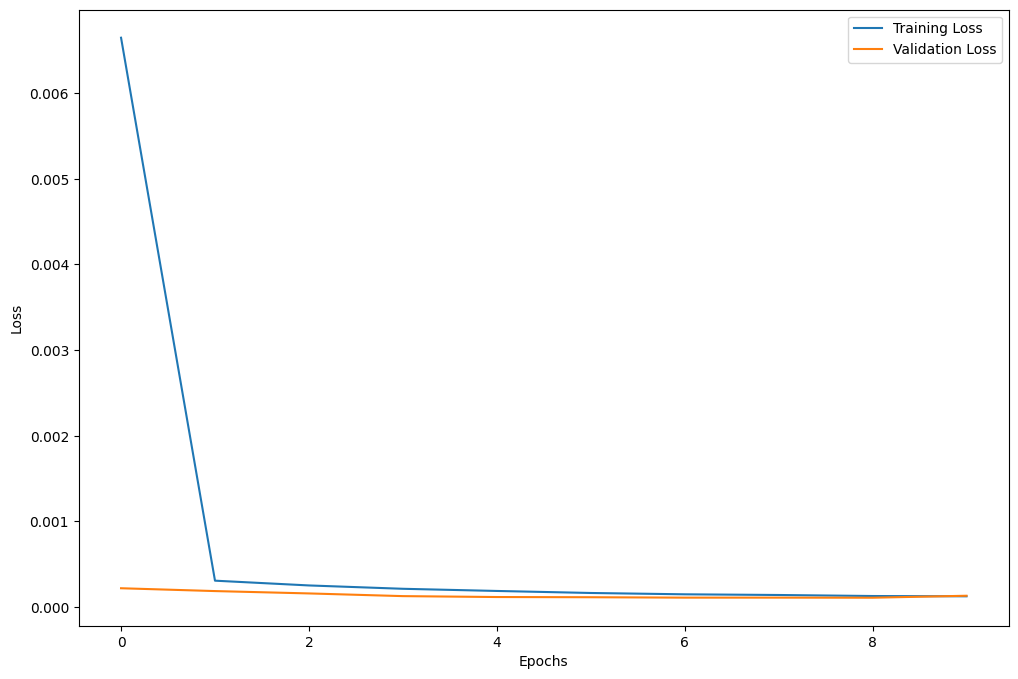

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(history.history["loss"], label="Training Loss");
plt.plot(history.history["val_loss"], label="Validation Loss");
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

### Threshold

Myös tässä tapauksessa threshold arvo saatiin todella pieneksi.

In [17]:
reconstructions = autoencoder.predict(X_train_norm)
train_loss = tf.keras.losses.mse(reconstructions, X_train_norm)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

7500/7500 [==============================] - 14s 2ms/step
Threshold:  0.0013995237777398827


### Kuvien piirtelyä

Aivan kuten pelkät UDP/LOIC-hyökkäykset sisältänyt data, myös molemmat hyökkäystyypit sisältävä data eroaa puhtaasta datasta hyvin selkeästi rekonstruktointi häviöiden perusteella, joten malli todennäköisesti toimii.

21492/21492 [==============================] - 40s 2ms/step


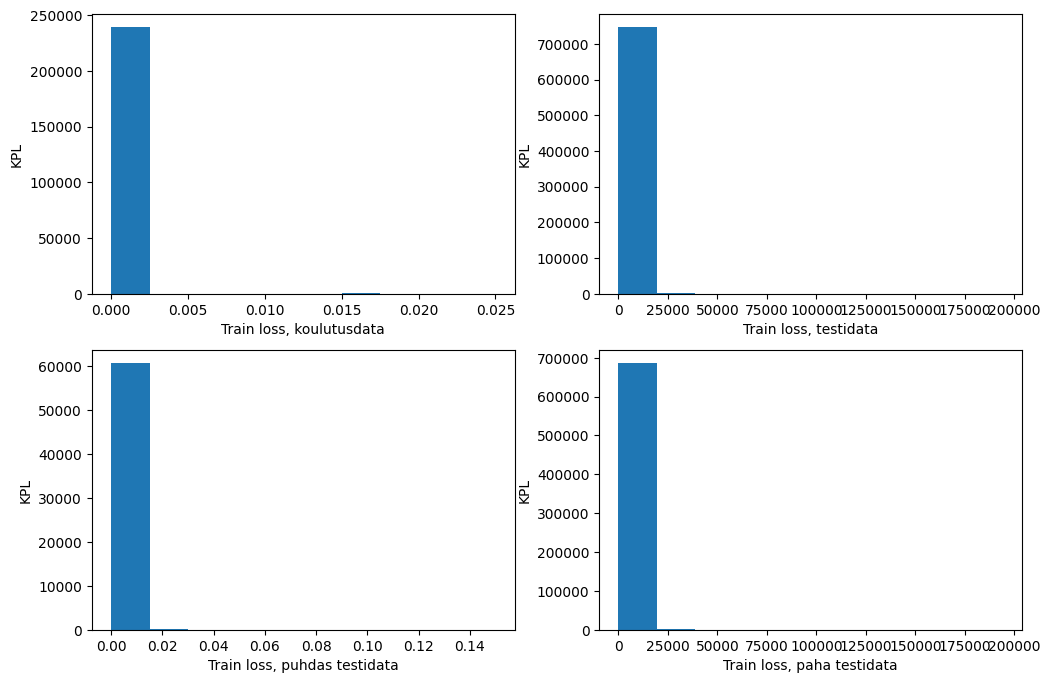

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(12,8))

reconstructions = autoencoder.predict(X_train_norm)
train_loss_training = tf.keras.losses.mse(reconstructions, X_train_norm)
threshold = np.mean(train_loss_training) + np.std(train_loss)
#print("Threshold: ", threshold)
ax[0, 0].hist(train_loss_training[None,:],range=[0, 0.025])
ax[0, 0].set_xlabel('Train loss, koulutusdata')
ax[0, 0].set_ylabel('KPL')

reconstructions = autoencoder.predict(X_test_norm)
train_loss_test = tf.keras.losses.mse(reconstructions, X_test_norm)
ax[0,1].hist(train_loss_test[None,:])
ax[0,1].set_xlabel('Train loss, testidata')
ax[0,1].set_ylabel('KPL')

reconstructions = autoencoder.predict(X_clean_test_norm)
train_loss_clean = tf.keras.losses.mse(reconstructions, X_clean_test_norm)
ax[1,0].hist(train_loss_clean[None,:], range=[0, 0.15])
ax[1,0].set_xlabel('Train loss, puhdas testidata')
ax[1,0].set_ylabel('KPL')

reconstructions = autoencoder.predict(X_evil_test_norm)
train_loss_evil = tf.keras.losses.mse(reconstructions, X_evil_test_norm)
ax[1,1].hist(train_loss_evil[None,:])
ax[1,1].set_xlabel('Train loss, paha testidata')
ax[1,1].set_ylabel('KPL')

plt.show()

### Tulokset

Kuten mittareista nähdään, malli toimii oikein hyvin molempien hyökkäysten havaitsemiseen. Todellisuudessa hyökkäystyypit pitäisi kuitenkin pystyä havaitsmeisvaiheessakin erottamaan jotenkin toisistaan.

In [19]:
def get_predictions(model, x_test_scaled, threshold):
  predictions = model.predict(x_test_scaled)
  errors = tf.keras.losses.mse(predictions, x_test_scaled)
  # 1 = poikkeama, 0 = normaali
  anomaly_mask = pd.Series(errors) > threshold
  preds = anomaly_mask.map(lambda x: 1.0 if x == True else 0.0)
  return preds

preds = get_predictions(autoencoder, X_test_norm, threshold)
print(accuracy_score(preds, T_test))
print(precision_score(preds, T_test))

print("\nLuokitteluraportti testidatalla:")
print(classification_report(T_test, preds, labels=[0, 1]))

23393/23393 [==============================] - 41s 2ms/step
0.999720802858765
1.0

Luokitteluraportti testidatalla:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     60833
           1       1.00      1.00      1.00    687742

    accuracy                           1.00    748575
   macro avg       1.00      1.00      1.00    748575
weighted avg       1.00      1.00      1.00    748575

